# La Liga Data Analysis

## Package Requirements & Database

In [45]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import seaborn as sns
import math

In [2]:
with sqlite3.connect("../laliga.sqlite") as con:
    df=pd.read_sql_query("SELECT * FROM Matches",con)
    dr=pd.read_sql_query("SELECT * FROM Predictions",con)

## Exercises

### Exercise 1
**Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.**

As can be seen in the pie chart below, it is indeed true that it is more likely for the home team to win, with a 52.8% chance. This is higher than the probability that there is a tie or that the away team wins.

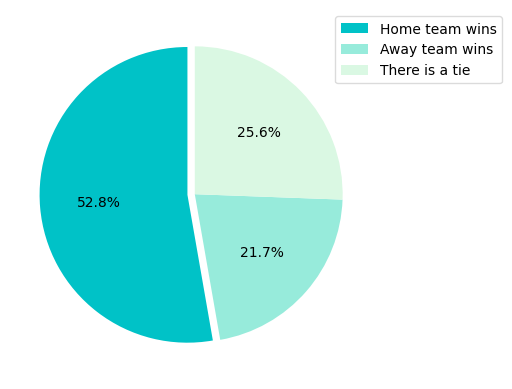

In [3]:
# Drop rows with missing values in the 'score' column
df = df.dropna(subset=['score'])

# Split the 'score' column into 'score_home_team' and 'score_away_team' columns
df[['score_home_team', 'score_away_team']] = df['score'].str.split(':', expand=True).astype(float)

# Calculate the results of each match
results = df['score_home_team'].sub(df['score_away_team'])

# Count the number of home wins, away wins, and ties
home_wins = (results > 0).sum()
away_wins = (results < 0).sum()
ties = (results == 0).sum()

# Create data for the pie chart
sizes = [home_wins, away_wins, ties]
labels = ['Home team wins', 'Away team wins', 'There is a tie']
explode = (0.05, 0.0, 0.0)
colors = ['#00c2c7', '#97ebdb', '#daf8e3']

# Plot the pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=['', '', ''], autopct='%1.1f%%', startangle=90, colors=colors)
ax.legend(wedges, labels, loc="upper right", bbox_to_anchor=(1.35, 1), fancybox=True, edgecolor='lightgrey', frameon=True)

plt.show()


### Exercise 2
**What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division. What have been the biggest wins? Of course, when we say _biggest_ we mean those with the highest goal difference. Show the top ten of them in a table.**

The ten highest scorers of the first division of La Liga can be seen in the two bar plot charts, respectively.

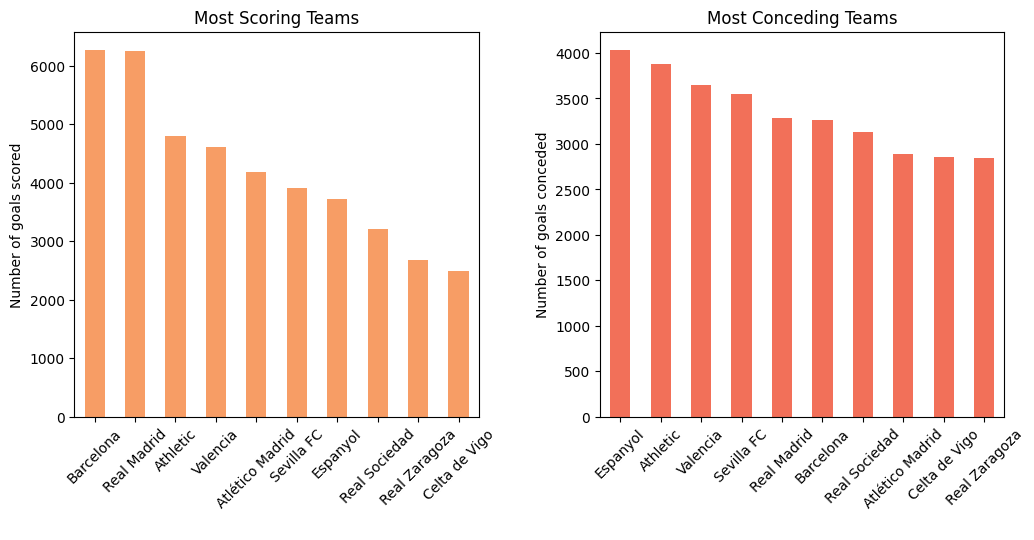

In [4]:
# Filter the DataFrame for the first division
df_first_division = df[df['division'] == 1].copy()

# Calculate total goals scored by each team & get the top 10 scoring teams
goals_scored = df_first_division.groupby('home_team')['score_home_team'].sum() + df_first_division.groupby('away_team')['score_away_team'].sum()
top_scorers = goals_scored.sort_values(ascending=False).head(10)

# Do the same for goals conceded by team and top conceding teams
goals_conceded = df_first_division.groupby('home_team')['score_away_team'].sum() + df_first_division.groupby('away_team')['score_home_team'].sum()
top_conceders = goals_conceded.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 5))

# Plot for the most scoring teams
plt.subplot(1, 2, 1)
top_scorers.plot(x='nombre', y='valor', kind='bar', color='#f79d65')
plt.xlabel(' ')
plt.ylabel('Number of goals scored')
plt.title('Most Scoring Teams')
plt.tick_params(axis='x', rotation=45)

# Plot for the most conceding teams
plt.subplot(1, 2, 2)
top_conceders.plot(x='nombre', y='valor', kind='bar', color='#f27059')
plt.xlabel(' ')
plt.ylabel('Number of goals conceded')
plt.title('Most Conceding Teams')
plt.tick_params(axis='x', rotation=45)

plt.subplots_adjust(wspace=0.3)
plt.show()


When it comes to the highest difference in scores per match in the first division, a table has also been created to display this information. As a highlight, the biggest difference there has ever been recorded until the moment the data was taken is 11 goals in an Athletic vs. Barcelona match.

In [5]:
# Calculate score difference and create game name column
df_first_division['score_difference'] = np.abs(df_first_division['score_home_team'] - df_first_division['score_away_team'])
df_first_division['game_name'] = df_first_division['home_team'] + ' vs ' + df_first_division['away_team']

# Select and rename relevant columns
differences = df_first_division[['score_difference', 'game_name']].sort_values(by='score_difference', ascending=False).head(10)
differences = differences.rename(columns={'score_difference': 'Score difference', 'game_name': 'Contestants'})

# Convert score difference to integer
differences['Score difference'] = differences['Score difference'].astype(int)

# Hide indices when displaying the DataFrame
differences.style.hide()

Score difference,Contestants
11,Athletic vs Barcelona
10,Sevilla FC vs Barcelona
10,Athletic vs Lérida
10,Athletic vs Celta de Vigo
10,Sevilla FC vs Real Oviedo
9,Barcelona vs Real Oviedo
9,Barcelona vs Rayo Vallecano
9,Racing vs Alavés
9,Real Madrid vs Elche CF
9,Atlético Madrid vs Hércules CF


### Exercise 3
**There has been a lot of discussion about how LaLiga’s television rights have changed game schedules in the last years. Make a bar plot chart showing the number of matches played each weekday, and make also a histogram of match time. Compare this two graphics between seasons 2000-2001 and 2020-2021.**

As can be seen in the bar plots below, this seems to indeed be the case if we consider the differences of the distributions number of games per day of the week in seasons 2000-2001 and 2020-2021. The games played in the 2000-2001 season are mostly concentrated around Saturday and Sunday, whereas the ones played in 2020-2021 are more distributed onto the weedays as well.

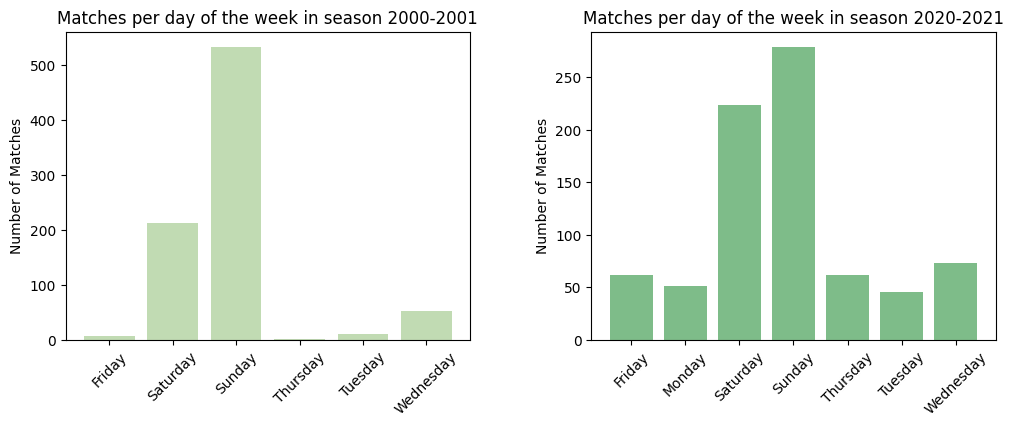

In [6]:
df_ex3 = df.copy() # Work with dataframe copy to assure the integrity of the data

# Convert the 'date' column to datetime
df_ex3['date'] = pd.to_datetime(df_ex3['date'], format='%m/%d/%y')

# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Define a function for plotting to reduce redundancy
def plot_day_of_week(ax, start_date, end_date, title, color):
    df_filtered = df_ex3[(df_ex3['date'] >= start_date) & (df_ex3['date'] <= end_date)]
    day_of_week_counts = df_filtered['date'].dt.day_name().value_counts().sort_index()
    ax.bar(day_of_week_counts.index, day_of_week_counts, color=color)
    ax.set_xlabel(' ')
    ax.set_ylabel('Number of Matches')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)

# Filter and plot data for 2000-2001
plot_day_of_week(axes[0], '2000-01-01', '2000-12-31', 'Matches per day of the week in season 2000-2001', '#c1dbb3')

# Filter and plot data for 2020-2021
plot_day_of_week(axes[1], '2020-01-01', '2020-12-31', 'Matches per day of the week in season 2020-2021', '#7ebc89')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)  # add space between subplots

plt.show()


A histogram of the times can be seen below.

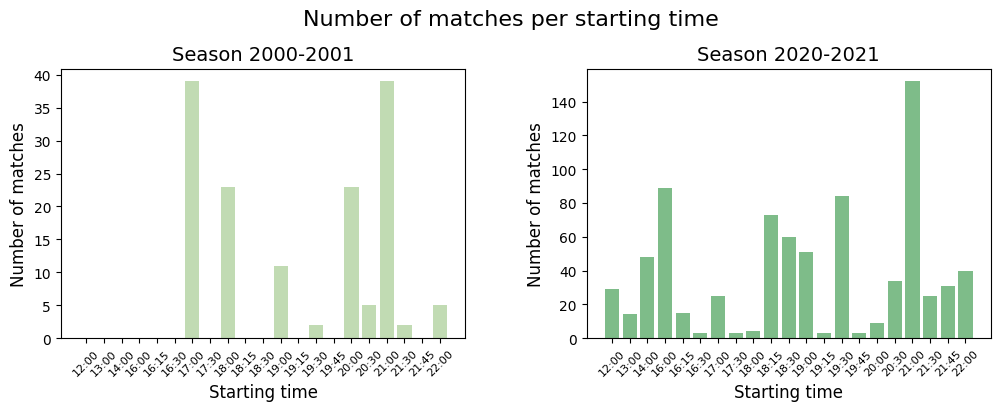

In [7]:
# Work with a copy to assure the integrity of the data
df_ex4 = df.copy()

# Convert 'date' and 'time' columns to datetime format
df_ex4["date"] = pd.to_datetime(df_ex4["date"], format="%m/%d/%y")
df_ex4["time"] = pd.to_datetime(df_ex4["time"], format="%I:%M %p", errors="coerce")

# Drop rows with NaN values in the 'time' column
df_ex4.dropna(subset=['time'], inplace=True)

# Define start and end dates for the two seasons
start_date_2000 = pd.Timestamp('2000-01-01')
end_date_2000 = pd.Timestamp('2000-12-31')
start_date_2020 = pd.Timestamp('2020-01-01')
end_date_2020 = pd.Timestamp('2020-12-31')

# Filter data for the two seasons
df_2000 = df_ex4[(df_ex4['date'] >= start_date_2000) & (df_ex4['date'] <= end_date_2000)]
df_2020 = df_ex4[(df_ex4['date'] >= start_date_2020) & (df_ex4['date'] <= end_date_2020)]

# Extract histograms for each season
hist_2000 = df_2000['time'].value_counts().sort_index()
hist_2020 = df_2020['time'].value_counts().sort_index()

# Determine the maximum x-axis for the histogram for consistent plotting
hist_max = hist_2000 if len(hist_2000) >= len(hist_2020) else hist_2020

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharex=True)
fig.subplots_adjust(wspace=0.3, hspace=0.5)

def plot_time_histogram(hist, hist_max, color, title):
    # Create subplot
    plt.bar(range(len(hist_max)), hist.reindex(index=hist_max.index, fill_value=0).values, width=0.8, color=color)
    plt.xlabel('Starting time', fontsize=12)
    plt.ylabel('Number of matches', fontsize=12)
    plt.xticks(range(len(hist_max)), hist_max.index.strftime('%H:%M'), rotation=45, fontsize=8)
    plt.title(title, fontsize=14)

# Plot for Season 2000-2001
plt.subplot(1, 2, 1)
plot_time_histogram(hist_2000, hist_max, '#c1dbb3', 'Season 2000-2001')

# Plot for Season 2020-2021
plt.subplot(1, 2, 2)
plot_time_histogram(hist_2020, hist_max, '#7ebc89', 'Season 2020-2021')

# Overall title
fig.suptitle('Number of matches per starting time', fontsize=16, y=1.05)

plt.show()

### Exercise 4

**Build a cross results table for season 2020-2021 (1st division). Figure 1 in the instructions is an example taken from Wikipedia. Try to make it the most similar to this one, painting the background of each cell according to result (green in case local team wins and red in case visitor team wins). Also, could you model the intensity of this background color with the goal difference from the match? Write a function that, given the season and division, plots the cross results table. Function prototype should be like plot_cross_results_table(season, division) and return the plot object.**

The code below, when executed, displays a cross table in which if the home team wins the background is color green, if the away team wins the background color is red and if there is a tie the background color is orange. 

In [16]:
# Filter data for the first division in the 2020-2021 season
df_season20_21 = df_first_division[df_first_division['season'] == '2020-2021']

# Create a pivot table
table = df_season20_21.pivot(index='home_team', columns='away_team', values='score')
table = table.fillna('-')

# Function to determine cell background color based on match results
def coloring(value):
    if value == '-':
        return ''  # Cells with '-' won't be colored
    else:
        home_score, away_score = map(int, value.split(":"))
        if home_score > away_score:
            return 'background-color: rgba(144, 238, 144, 0.55)'  # Green for home team win
        elif home_score < away_score:
            return 'background-color: rgba(255, 37, 44, 0.7)'  # Red for away team win
        else:
            return 'background-color: rgb(255, 179, 71); color: black'  # Orange for a draw

# Apply the coloring function to the entire styled DataFrame
colored_table = table.style.map(coloring)

# Display the styled table
colored_table

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


#### **Could you model the intensity of this background color with the goal difference from the match?**

The code below does the same as the one in the cell above, but now we asign a difference intensity of the code according to the value of the difference between the score of the home team and the away team: as more different are the scores, the brighter the color gets.

In [30]:
# Filter data for the first division in the 2020-2021 season
df_season20_21 = df_first_division[df_first_division['season'] == '2020-2021']

# Create a pivot table
table = df_season20_21.pivot(index='home_team', columns='away_team', values='score')
table = table.fillna('-')

# Calculate the maximum difference between scores when the home team wins and when the away team wins
max_dif_homewins = (df_season20_21['score_home_team'] - df_season20_21['score_away_team']).max()
max_dif_awaywins = (-df_season20_21['score_home_team'] + df_season20_21['score_away_team']).max()

# Function for coloring, now with gradients
def coloring_gradients(value):
    if value == '-':
        return ''
    else:
        parts = value.split(":")
        home_score, away_score = map(float, parts)
        if home_score > away_score:
            alpha = (home_score - away_score) / max_dif_homewins
            # Set a threshold for transparency to ensure readability
            alpha = min(alpha, 0.8)
            return f'background-color:rgba(144, 238, 144, {alpha});color:black' if alpha >= 0.8 else f'background-color:rgba(144, 238, 144, {alpha});color:white'
        elif home_score < away_score:
            alpha = (-home_score + away_score) / max_dif_awaywins
            return f'background-color:rgba(255, 37, 44, {alpha})'
        else:
            return 'background-color:rgb(255, 179, 71); color:black'

# Apply the coloring function to the entire styled DataFrame
colored_table = table.style.map(coloring_gradients)

# Display the styled table
display(colored_table)

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


#### **Write a function that, given the season and the division, plots the cross section results table**

Since we have two types of table created, we have two functions according to the type of colors you want (if you want the gradient or not). Table without the gradient:

In [38]:
# Function to create a colored table for any division and season
def table_for_any_season(x,y):
    df_unknown_div= df[df['division']==x]
    df_any_season=df_unknown_div[df_unknown_div['season']==y]
    table_any_seas=df_any_season.pivot_table(index='home_team', columns='away_team',values='score',aggfunc=list,fill_value='-',margins=False)
    table_any_seas=table.fillna('-')
    colored_table=table_any_seas.style.map(coloring) 
    return colored_table
    
#If you want to try the function with more values make sure to put first the number of the division (1 or 2) and the season with format 'year-year'
display(table_for_any_season(1,'2013-2012')) 

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


Table with the gradient:

In [39]:
# Function to create a colored table for any division and season with the gradient
def table_for_any_season_with_gradient(x,y):
    df_unknown_div= df[df['division']==x]
    df_any_season=df_unknown_div[df_unknown_div['season']==y]
    table_any_seas=df_any_season.pivot_table(index='home_team', columns='away_team',values='score',aggfunc=list,fill_value='-',margins=False)
    table_any_seas=table.fillna('-')
    colored_table_gradient=table_any_seas.style.map(coloring_gradients) 
    return colored_table_gradient

# Same recquirements as before, first write the function (1 or 2) and then the season as 'year-year'
display(table_for_any_season_with_gradient(2,'2001-2000'))


away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


### Exercise 5

**As you surely know, there has always been a historical rivalry between Barcelona and Real Madrid. But which of them has won the most games in direct confrontations? Which of them has scored the most goals in these games? Show both things in two pie charts, side by side. Remember to consider ties in the first one. Write a function that, given two team names, plots the two graphs described above. Function prototype should be like plot_direct_confrontations_- stats(team1, team2) and return the plot object. Use it with some other classical rivals like Betis and Sevilla.**

In direct confrontations, the data reflects that Madrid has won more by a very small difference. The same is true for the number of goals scored. However, the difference is in the order of 0.5% in both cases, which keeps future games very interesting with remarkably tie odds of winning.

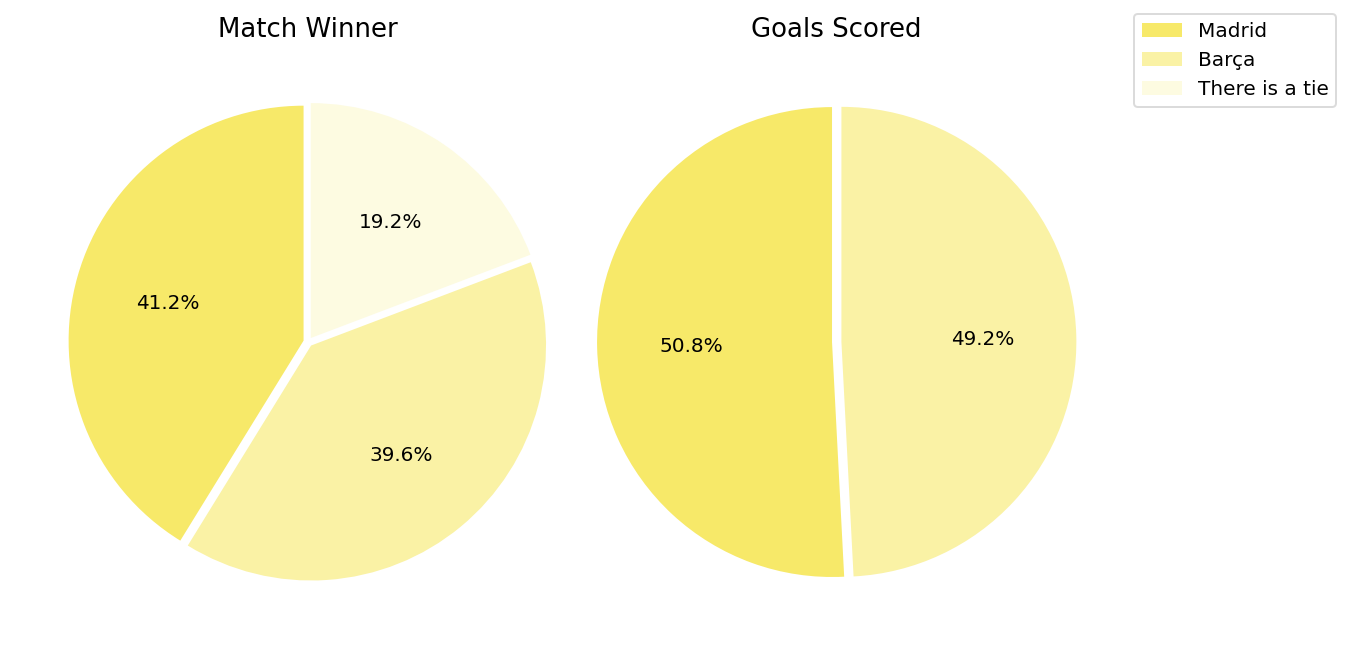

In [40]:
# Filter data for Real Madrid home matches against Barcelona & calculate total goals scored my Real Madrid in these matches
df_home_madrid = df[df['home_team'] == 'Real Madrid'][df[df['home_team'] == 'Real Madrid']['away_team'] == 'Barcelona']
goals_madrid = df_home_madrid['score_home_team'].sum()

# Filter data for Barcelona home matches against Real Madrid & calculate total goals scored by Barcelona in these matches
df_home_barca = df[df['home_team'] == 'Barcelona'][df[df['home_team'] == 'Barcelona']['away_team'] == 'Real Madrid']
goals_barca = df_home_barca['score_home_team'].sum()

# Combine data for Real Madrid and Barcelona matches
df_bar_vs_mad = pd.concat([df_home_madrid, df_home_barca])

# Count the number of wins for Real Madrid and Barcelona
madrid_wins = (df_home_madrid['score_home_team'] > df_home_madrid['score_away_team']).sum() + (
        df_home_barca['score_home_team'] < df_home_barca['score_away_team']).sum()
barca_wins = (df_home_barca['score_home_team'] > df_home_barca['score_away_team']).sum() + (
        df_home_madrid['score_home_team'] < df_home_madrid['score_away_team']).sum()
# Count the number of ties
ties = (df_bar_vs_mad['score_home_team'] == df_bar_vs_mad['score_away_team']).sum()

fig = plt.figure(figsize=(10, 10), dpi=144)

# Plot for Match Winner
sizes = [madrid_wins, barca_wins, ties]
labels = [' ', ' ', ' ']
explode = (0.02, 0.02, 0.02)
plt.subplot(1, 2, 1)
colors1 = ['#f7e969', '#faf2a5', '#fdfbe1']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors1)
plt.title('Match Winner', fontsize=13)

# Plot for Goals Scored
sizes = [goals_madrid, goals_barca]
labels = [' ', ' ']
explode = (0.02, 0.02)
plt.subplot(1, 2, 2)
colors2 = ['#f7e969', '#faf2a5']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors2)
plt.title('Goals Scored', fontsize=13)

plt.subplots_adjust(wspace=-0.1)

# Add legend
legend_labels = ['Madrid', 'Barça', 'There is a tie']
legend_colors = ['#f7e969', '#faf2a5', '#fdfbe1', '#f7e969', '#faf2a5']
fig.legend(labels=legend_labels, loc='upper right', bbox_to_anchor=(1.05, 0.73), prop={'size': 10}, fancybox=True,
           edgecolor='lightgrey', frameon=True)

plt.show()


Below is the function by which the action of comparing the statistics of the direct confrontation of two teams in LaLiga can be seen. As an example, it is called for Real Betis vs. Sevilla FC.

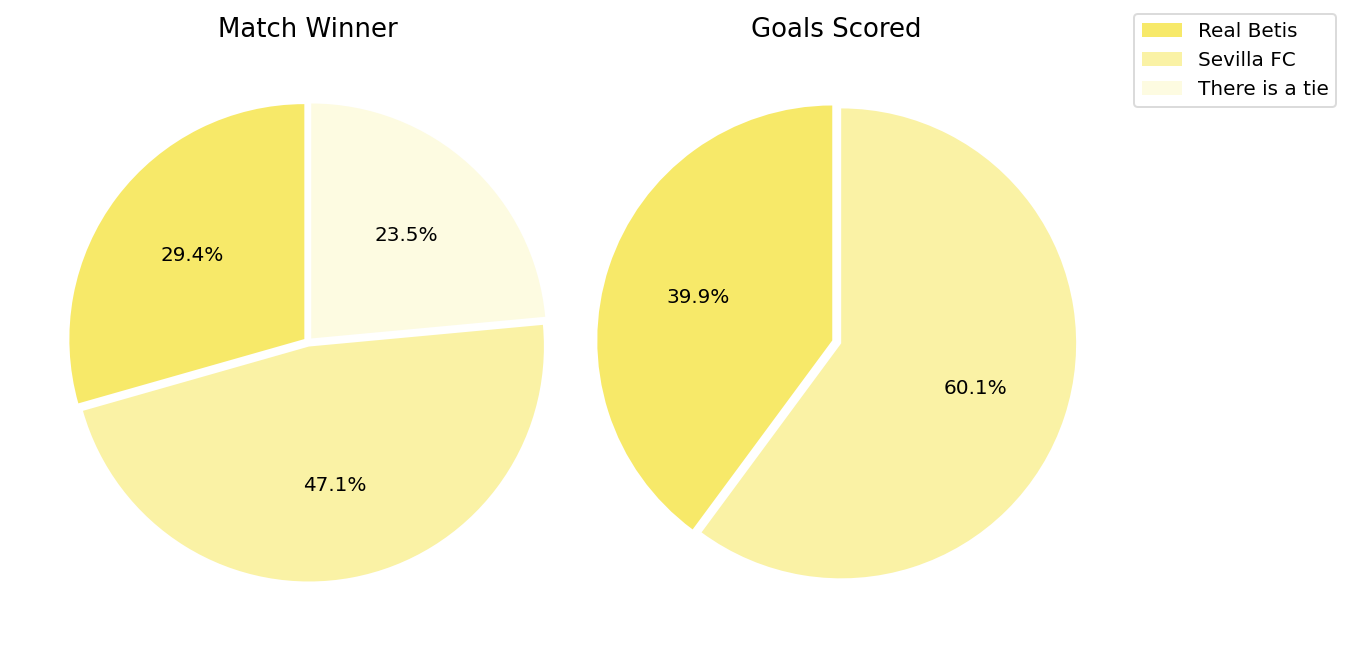

In [41]:
def plot_direct_confrontations_stats(team1, team2):
    # Filter data for matches where team1 is the home team and team2 is the away team, calculate total team1 goals
    df_home_team1 = df[df['home_team'] == team1][df[df['home_team'] == team1]['away_team'] == team2]
    goals_team1 = df_home_team1['score_home_team'].sum()

    # Filter data for matches where team2 is the home team and team1 is the away team, calculate total team2 goals
    df_home_team2 = df[df['home_team'] == team2][df[df['home_team'] == team2]['away_team'] == team1]
    goals_team2 = df_home_team2['score_home_team'].sum()

    # Combine data for direct confrontations
    df_team1_vs_team2 = pd.concat([df_home_team1, df_home_team2])

    # Count the number of wins for team1 and team2, and ties
    team1_wins = (df_home_team1['score_home_team'] > df_home_team1['score_away_team']).sum() + (
            df_home_team2['score_home_team'] < df_home_team2['score_away_team']).sum()
    team2_wins = (df_home_team2['score_home_team'] > df_home_team2['score_away_team']).sum() + (
            df_home_team1['score_home_team'] < df_home_team1['score_away_team']).sum()
    ties = (df_team1_vs_team2['score_home_team'] == df_team1_vs_team2['score_away_team']).sum()

    fig = plt.figure(figsize=(10, 10), dpi=144)

    # Plot for Match Winner
    sizes = [team1_wins, team2_wins, ties]
    labels = [' ', ' ', ' ']
    explode = (0.02, 0.02, 0.02)
    plt.subplot(1, 2, 1)
    colors1 = ['#f7e969', '#faf2a5', '#fdfbe1']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors1)
    plt.title('Match Winner', fontsize=13)

    # Plot for Goals Scored
    sizes = [goals_team1, goals_team2]
    labels = [' ', ' ']
    explode = (0.02, 0.02)
    plt.subplot(1, 2, 2)
    colors2 = ['#f7e969', '#faf2a5']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors2)
    plt.title('Goals Scored', fontsize=13)

    plt.subplots_adjust(wspace=-0.1)

    # Add legend with team names and 'Tie'
    legend_labels = [f'{team1}', f'{team2}', 'There is a tie']
    legend_colors = ['#f7e969', '#faf2a5', '#fdfbe1', '#f7e969', '#faf2a5']
    fig.legend(labels=legend_labels, loc='upper right', bbox_to_anchor=(1.05, 0.73), prop={'size': 10}, fancybox=True,
               edgecolor='lightgrey', frameon=True)

    plt.show()

# Example usage of the function with teams 'Real Betis' and 'Sevilla FC'
plot_direct_confrontations_stats('Real Betis', 'Sevilla FC')

### Exercise 6
**Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the longest undefeated streaks in a horizontal bar plot, indicating in each bar the team name and the dates it held that streak, for instance, Real Sociedad 22/04/1979 - 04/05/1980.**

In [52]:
# Function for preprocessing the input dataframe
def preprocessing(input_df):
    # Filter rows with non-null 'score' values
    filtered_score_df = input_df[input_df['score'].notna()].copy()
    
    # Split 'score' into 'home_score' and 'away_score'
    split_scores = filtered_score_df['score'].str.split(':', expand=True).astype(int)
    filtered_score_df['home_score'] = split_scores[0]
    filtered_score_df['away_score'] = split_scores[1]
    
    return filtered_score_df

# Function to format the date in the dataframe
def format_date(df):
    # Split 'date' into 'day', 'month', and 'year'
    split_dates = df['date'].str.split('/', expand=True).astype(int)
    df_copy = df.copy()
    df_copy['day'] = split_dates[1]
    df_copy['month'] = split_dates[0]
    df_copy['year'] = split_dates[2]

    # Correct the year values
    def correct_year(year):
        if year > 25:
            return year + 1900
        else:
            return year + 2000
    df_copy['year'] = df_copy['year'].apply(correct_year)
    
    # Create a new 'date1' column with datetime format
    df_copy['date1'] = pd.to_datetime(df_copy[['year', 'month', 'day']])
    
    return df_copy

# Function to separate wins, loses, and ties in the DataFrame
def separate_wins_loses_ties(df_filtered):
    # Create new columns for wins, loses, and ties
    df_filtered['Win_home'] = np.where(df_filtered['home_score'] > df_filtered['away_score'], 1, 0)
    df_filtered['Win_away'] = np.where(df_filtered['home_score'] < df_filtered['away_score'], 1, 0)
    df_filtered['Ties'] = np.where(df_filtered['home_score'] == df_filtered['away_score'], 1, 0)

    # Concatenate DataFrame for home and away teams
    df_teams = pd.concat([df_filtered.rename(columns={'home_team': 'team', 'Win_home': 'Win','Win_away':'Lose', 'home_score' : 'GF', 'away_score': 'GA',}),
                         df_filtered.rename(columns={'away_team': 'team', 'Win_away': 'Win','Win_home':'Lose', 'home_score' : 'GA', 'away_score': 'GF'})], ignore_index=True)
    
    return df_teams

# Preprocess the input dataframe
df_filtered = preprocessing(df.copy())

# Separate wins, loses, and ties
df_teams = separate_wins_loses_ties(df_filtered)

# Format the date in the DataFrame
df_teams = format_date(df_teams)

# Sort the DataFrame by team and date
df_teams = df_teams.sort_values(by=['team', 'date1'])

# Create additional columns for streak calculation
df_teams['team_changed'] = df_teams['team'] != df_teams['team'].shift(1)
df_teams['streak_start'] = (df_teams['Lose'] == 0) & (df_teams['Lose'].shift(1) != 1) | df_teams['team_changed']
df_teams['streak_decrement'] = (df_teams['streak_start'] == False).astype(int)
df_teams['streak'] = df_teams['streak_decrement'].cumsum().sub(1)

# Count streak occurrences
streak_counts = df_teams['streak'].value_counts()
max_values = streak_counts.head(10)

# Find first and last indices for each top streak
Firsts = []
Lasts = []
for i in range(len(max_values)):
    first_index = (df_teams[df_teams['streak'] == max_values.index[i]]['streak'].idxmin())
    last_index = (df_teams[df_teams['streak'] == max_values.index[i]][::-1]['streak'].idxmin())
    Firsts.append(first_index)
    Lasts.append(last_index)
    df_teams.loc[first_index, 'Rows'] = max_values.iloc[i]
    df_teams.loc[last_index, 'Rows'] = max_values.iloc[i]

# Select rows with the first and last indices for each top streak
selected_rows = df_teams.loc[Firsts+Lasts]

# Extract relevant columns and sort the DataFrame
df_clean = selected_rows[['team', 'date1', 'Rows']]
df_clean = df_clean.sort_values(by=['team', 'date1']).reset_index().reset_index()

# Create a 'Marker' column and group the DataFrame
df_clean['Marker'] = df_clean['level_0'].apply(lambda x: math.trunc(x / 2))
df_clean = df_clean.groupby(['team', 'Marker', 'Rows'])['date1'].agg(lambda x: 'a'.join(x.dt.strftime('%d-%m-%Y'))).reset_index()

# Sort and clean the DataFrame
df_clean = df_clean.sort_values(by='Rows', ascending=False).reset_index()
df_clean = df_clean.drop(columns=['Marker', 'index'])
df_clean['date1'] = df_clean['date1'].str.replace('-', '/').str.replace('a', '-')
df_clean = df_clean[['Rows', 'team', 'date1']]

# Display the final DataFrame
print(df_clean)

   Rows             team                  date1
0  43.0        Barcelona  15/04/2017-09/05/2018
1  38.0    Real Sociedad  29/04/1979-04/05/1980
2  31.0        Barcelona  19/09/2010-23/04/2011
3  31.0      Real Madrid  08/05/1988-09/04/1989
4  29.0      Real Madrid  11/11/1989-02/09/1990
5  29.0      Real Madrid  28/04/1996-15/02/1997
6  29.0  Real Valladolid  07/10/2006-29/04/2007
7  28.0      Real Madrid  02/03/2016-07/01/2017
8  27.0      Real Madrid  15/09/1968-30/03/1969
9  26.0        Barcelona  07/10/1973-21/04/1974


### Exercise 7
**Create a table with the final standings of each season (and division), that is, a table that contains all the teams ordered (in descending order) by the number of points they got during that season, and some other aggregate statistics. The table must contain the following columns: season, division, ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of 1st division come before standings of 2nd division.**


In [55]:
# Calculate the Winner column: 1 if home team wins, 0 if away team wins, -1 if tie
df['Winner'] = np.where(df['score_home_team'] > df['score_away_team'], 1, np.where(df['score_home_team'] < df['score_away_team'], 0, -1))

# Define functions to count wins, losses, and ties
def func_home_wins(data):
    return (data[data == 1]).count()

def func_away_wins(data):
    return (data[data == 0]).count()

def func_tie(data):
    return (data[data == -1]).count()

# Group by home team for classification
df_class_home = df.groupby(['division', 'season', 'home_team']).agg(
    GF=pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    GA=pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    W=pd.NamedAgg(column='Winner', aggfunc=func_home_wins),
    L=pd.NamedAgg(column='Winner', aggfunc=func_away_wins),
    T=pd.NamedAgg(column='Winner', aggfunc=func_tie)
).reset_index()

# Group by away team for classification
df_class_away = df.groupby(['division', 'season', 'away_team']).agg(
    GF=pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    GA=pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    W=pd.NamedAgg(column='Winner', aggfunc=func_away_wins),
    L=pd.NamedAgg(column='Winner', aggfunc=func_home_wins),
    T=pd.NamedAgg(column='Winner', aggfunc=func_tie)
).reset_index()

# Rename columns and merge home and away classifications
df_class_away.rename(columns={'away_team': 'team'}, inplace=True)
df_class_home.rename(columns={'home_team': 'team'}, inplace=True)
df_classification = df_class_away.merge(df_class_home, how='outer')

# Sum values for each team across seasons and divisions
df_classification = df_classification.groupby(['season', 'team', 'division']).sum().reset_index()

# Calculate goal difference (GD) and points (Pts)
df_classification['GD'] = df_classification['GF'] - df_classification['GA']
df_classification['Pts'] = (df_classification['W']) * 3 + df_classification['T']

# Extract the starting year from the season column
df_classification['year_of_start'] = df_classification['season'].str.split("-").str[0].astype(int)

# Sort the DataFrame for ranking
df_classification_ordered = df_classification.sort_values(by=['year_of_start'], ascending=False)
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division'], ascending=[False, True])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'Pts'], ascending=[False, True, False])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'Pts', 'GD'], ascending=[False, True, False, False])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'Pts', 'GD', 'GF'], ascending=[False, True, False, False, False])

# Reset index and calculate the rank within each season and division
df_classification_ordered = df_classification_ordered.reset_index(drop=True)
df_classification_ordered['rank'] = df_classification_ordered.groupby(['year_of_start', 'division']).cumcount() + 1

# Select relevant columns for the final classification
df_final_classification_ordered = df_classification_ordered[['season','division','rank','team','GF','GA','GD','W','L','T','Pts']]

# Reset the index starting from 1
df_final_classification_ordered.reset_index(drop=True, inplace=True)
df_final_classification_ordered.index += 1

# Save the final classification to an Excel file
df_final_classification_ordered.to_excel('../reports/SeasonStandings.xlsx', index=False)

### Exercise 8

##### Villarreal is a team that has grown a lot in recent decades. Specially ever since some billionaire guy bought it (Fernando Roig, from Mercadona). Make a line plot showing the rank of Villarreal at the end of each season, from the oldest ones (left) to the earliest ones (right). Consider rankings in 2nd division to be a continuation of the 1st one, that is, if there’s N teams in 1st division and Villarreal got r position in 2nd division, then it should be placed in N +r. Draw in the same plot a line showing the cut between 1st and 2nd division



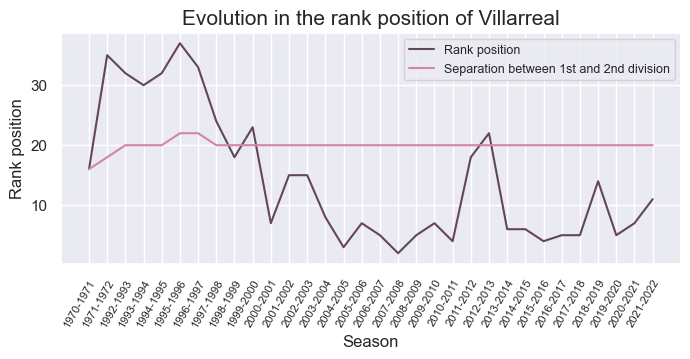

In [56]:
# Obtain data for Villarreal in Division 1
df_villarreal_1 = df_final_classification_ordered[(df_final_classification_ordered['team'] == 'Villarreal') & (df_final_classification_ordered['division'] == 1.0)]

# Obtain data for Villarreal in Division 2
df_villarreal_2 = df_final_classification_ordered[(df_final_classification_ordered['team'] == 'Villarreal') & (df_final_classification_ordered['division'] == 2.0)]
seasons_villarreal_2 = df_villarreal_2['season']

# DataFrame of all teams in Division 1 when Villarreal was in Division 2
df_total_v2 = df_final_classification_ordered[(df_final_classification_ordered['season'].isin(seasons_villarreal_2)) & (df_final_classification_ordered['division'] == 1.0)]

# Find the lowest rank position for each season in Division 1 when Villarreal was in Division 2
lowest_rank_div1 = df_total_v2.groupby(['season'])['rank'].max().reset_index()
df_villarreal_2 = df_villarreal_2.merge(lowest_rank_div1, how='outer')
df_villarreal_2_final = df_villarreal_2.groupby(['season']).sum().reset_index()

# Join both DataFrames and sort them by year
df_villarreal = df_villarreal_1.merge(df_villarreal_2_final, how='outer')
df_villarreal['year_start'] = df_villarreal['season'].str.split('-').str[0].astype(int)
df_villarreal_ordered = df_villarreal.sort_values(by=['year_start'], ascending=[True])

# Obtain the lowest ranking for each season in Division 1
total_seasons_villarreal = df_villarreal_ordered['season']
df_total = df_final_classification_ordered[(df_final_classification_ordered['season'].isin(total_seasons_villarreal))]
df_total_div1 = df_total[df_total['division'] == 1]
df_total_lowest_in_rank_div1 = df_total_div1.groupby(['season'])['rank'].max().reset_index()
# Rename the column to avoid conflicts
df_total_lowest_in_rank_div1_renamed = df_total_lowest_in_rank_div1.rename(columns={'rank': 'lowest_in_1'})
df_villarreal_ordered = df_villarreal_ordered.merge(df_total_lowest_in_rank_div1_renamed, on='season', how='inner')

# Plotting the graphic
sns.set_theme()
fig = plt.figure(figsize=(8, 3))
sns.lineplot(data=df_villarreal_ordered, x='season', y='rank', color="#63465A", label='Rank position')
plt.xticks(rotation=60, ha='right', rotation_mode='anchor', fontsize=8)
plt.xlabel('Season')
plt.ylabel('Rank position')
sns.lineplot(data=df_villarreal_ordered, x='season', y='lowest_in_1', label='Separation between 1st and 2nd division', color='#d484aa')

plt.legend(fontsize=9)
plt.title('Evolution in the rank position of Villarreal', fontsize=15)
plt.show()

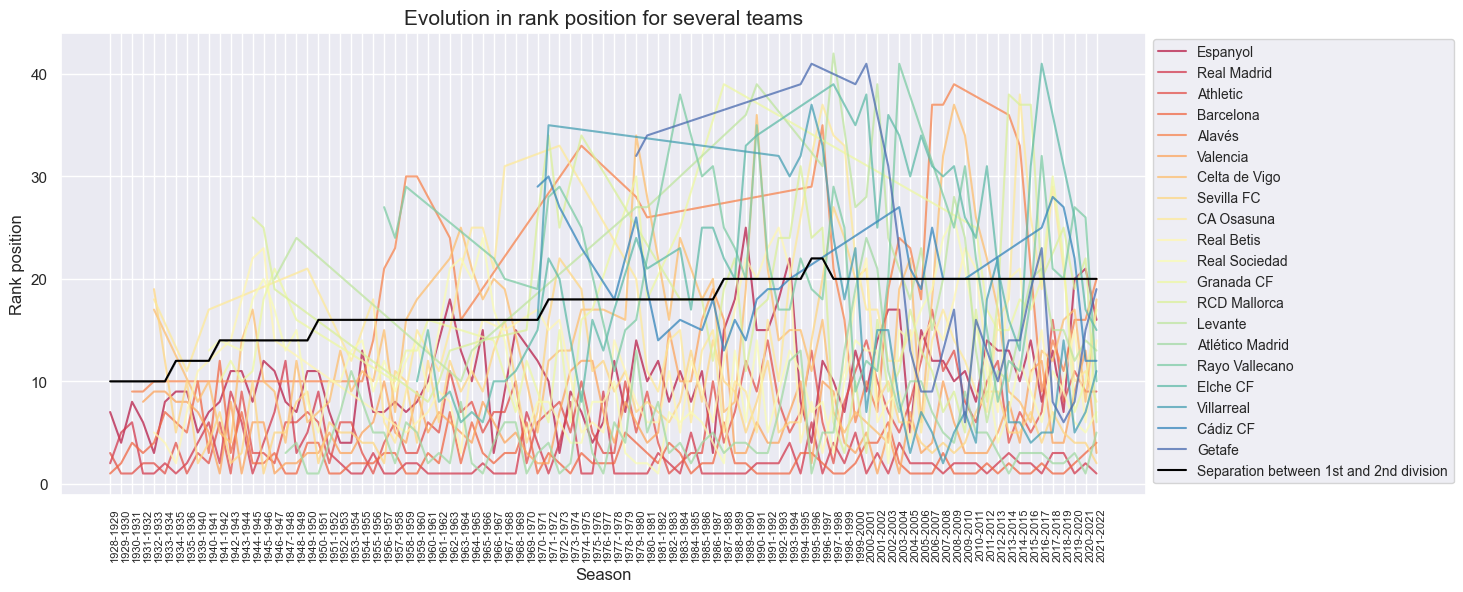

In [57]:
# Function that works in the same way as the code above, but with several teams
def plot_ranking_evolution(*teams):
    df_plot=pd.DataFrame() # Defining an empty df that helps us ataching the data of the funcion into it!!
     
    for team in teams:
        # This is the same procedure as in the code above, but for an undefined team 
        df_current_iter=df_final_classification_ordered[df_final_classification_ordered['team']==team]
        df_plot_div1=df_current_iter[df_current_iter['division']==1.0]
        df_plot_div2=df_current_iter[df_current_iter['division']==2.0]
        seasons_team_div2=df_plot_div2['season']
        df_team_in2=df_final_classification_ordered[df_final_classification_ordered['season'].isin(seasons_team_div2)]
        df_team_in2_div1=df_team_in2[df_team_in2['division']==1.0]
        lowest_rank_div1=df_team_in2_div1.groupby('season')['rank'].max().reset_index()
        df_plot_div2=df_plot_div2.merge(lowest_rank_div1,how='outer')
        df_plot_div2_final= df_plot_div2.groupby(['season']).sum().reset_index()
        df_team=df_plot_div1.merge( df_plot_div2_final,how='outer')
        df_plot=pd.concat([df_plot,df_team]) # Attaching all the data to the same dataframe 
    # Ordering the dataframe according to the season!!
    df_plot['year_start']=df_plot['season'].str.split('-').str[0].astype(int)
    df_plot_ordered=df_plot.sort_values(by=['year_start'],ascending=[True])
    
    # Same as before, but now we have the dataframe for all the teams we want to display
    total_seasons_plot=df_plot_ordered['season']
    df_all_seasons=df_final_classification_ordered[(df_final_classification_ordered['season'].isin(total_seasons_plot))]
    df_all_seasons_div1=df_all_seasons[df_all_seasons['division']==1.0]
    df_total_lowest_in_rank=df_all_seasons_div1.groupby(['season'])['rank'].max().reset_index()
    df_total_lowest_in_rank_renamed=df_total_lowest_in_rank.rename(columns={'rank':'lowest_in_1'})
    df_plot_ordered=df_plot_ordered.merge(df_total_lowest_in_rank_renamed,on='season',how='inner')
    

    # Plotting the graphic again
    sns.set_theme()
    fig=plt.figure(figsize=(14,6))
    sns.lineplot(data=df_plot_ordered,x='season',y='rank',hue='team',palette='Spectral',alpha=0.75)
    sns.lineplot(data=df_plot_ordered,x='season',y='lowest_in_1',color='black',label='Separation between 1st and 2nd division')
    plt.xticks(rotation=90, ha='right',rotation_mode='anchor', fontsize=8)
    plt.xlabel('Season')
    plt.ylabel('Rank position')
    plt.legend( bbox_to_anchor=(1, 1), loc='upper left',fontsize=10)
    plt.title('Evolution in rank position for several teams', fontsize=15)
    plt.show()

plot_ranking_evolution('Real Madrid', 'Sevilla FC', 'Valencia', 'Barcelona', 'Atlético Madrid', 'RCD Mallorca', 'Real Sociedad', 'CA Osasuna', 'Athletic', 'Rayo Vallecano', 'Villarreal', 'Cádiz CF', 'Levante', 'Real Betis', 'Elche CF', 'Espanyol', 'Granada CF', 'Celta de Vigo', 'Getafe', 'Alavés')


### Exercise 9

**In football jargon, those teams that are permanently descending and ascending between 1st and 2nd division are called elevator teams. What are the most elevator teams in LaLiga? Plot the history of the top 5 of them using the function from exercise 8.**

The top 5 most 'elevator teams' in history is Barcelona, Athletic, Real Madrid, Espanyol and Valencia.

The most elevator teams in LaLiga are: ['Racing', 'CA Osasuna', 'Real Betis', 'UD Las Palmas', 'Real Oviedo']


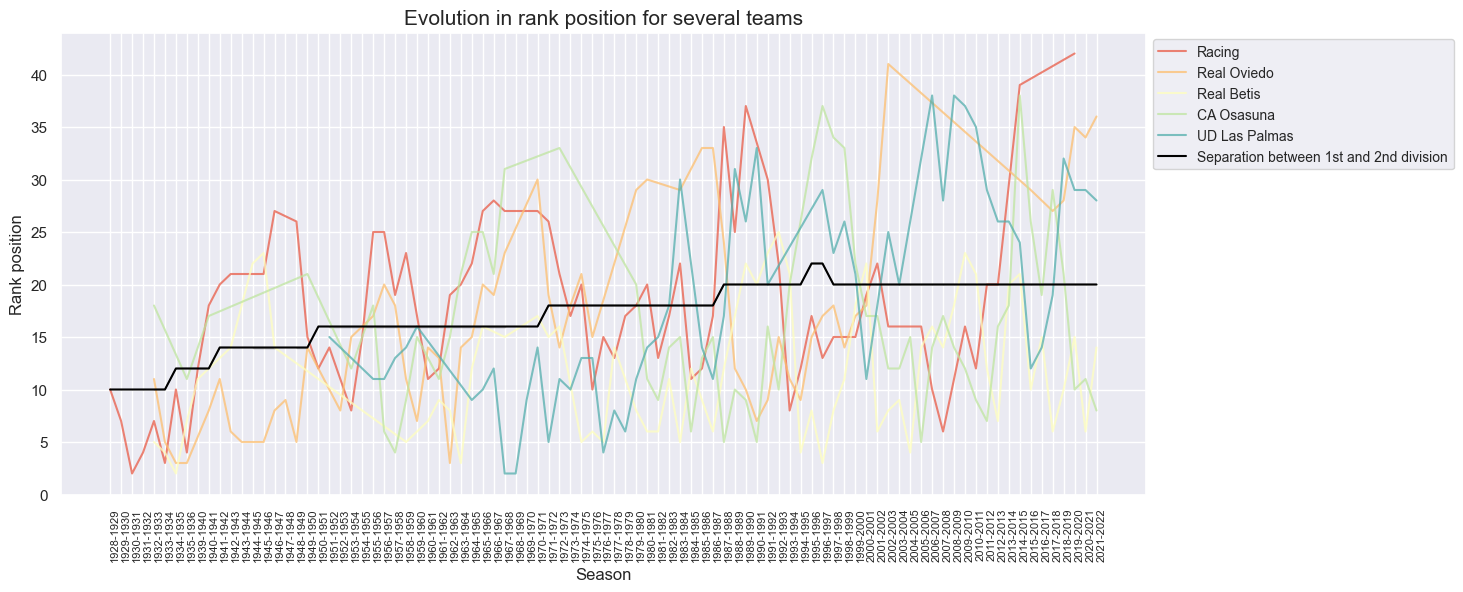

In [59]:
# Function that counts the division shifts of a team
def division_changes(data):
    return ((data != data.shift()).astype(int)).count()

# Applying the function to our teams for every season
df_division_changes = df.groupby(['home_team', 'season'])['division'].agg(division_changes).reset_index()

# Sorting the teams based on the number of division changes in descending order and selecting the top 5
df_top5_elevator_teams = df_division_changes.sort_values(by='division', ascending=False).head(5).reset_index()

# Creating a list of the top 5 elevator teams and printing it
list_elevator_teams = df_top5_elevator_teams['home_team'].tolist()
print('The most elevator teams in LaLiga are:', list_elevator_teams)
plot_ranking_evolution('Racing', 'CA Osasuna', 'Real Betis', 'UD Las Palmas', 'Real Oviedo')

### Exercise 10

In [62]:
# Group by home team for classification
df_class_home = df.groupby(['division', 'season', 'matchday', 'home_team', 'Winner']).agg(
    GF_safe=pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    GA_safe=pd.NamedAgg(column='score_away_team', aggfunc='sum')
).reset_index()

# Group by away team for classification
df_class_away = df.groupby(['division', 'season', 'matchday', 'away_team', 'Winner']).agg(
    GF_safe=pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    GA_safe=pd.NamedAgg(column='score_home_team', aggfunc='sum')
).reset_index()

# Create columns for wins, losses, and ties
df_class_home['W_safe'] = np.where(df_class_home['Winner'] == 1, 1, 0)
df_class_home['L_safe'] = np.where(df_class_home['Winner'] == 0, 1, 0)
df_class_home['T_safe'] = np.where(df_class_home['Winner'] == -1, 1, 0)

df_class_away['W_safe'] = np.where(df_class_away['Winner'] == 0, 1, 0)
df_class_away['L_safe'] = np.where(df_class_away['Winner'] == 1, 1, 0)
df_class_away['T_safe'] = np.where(df_class_away['Winner'] == -1, 1, 0)

# Rename columns and merge home and away classifications
df_class_away.rename(columns={'away_team': 'team'}, inplace=True)
df_class_home.rename(columns={'home_team': 'team'}, inplace=True)
df_classification = df_class_away.merge(df_class_home, how='outer')

# Sum values for each team across seasons, divisions, and matchdays
df_classification = df_classification.groupby(['season', 'division', 'matchday', 'team']).sum().reset_index()

# Cumulative sum for wins, losses, goals for, and goals against
df_classification[['W', 'L', 'T', 'GF', 'GA']] = df_classification.groupby(['division', 'season', 'team'])[['W_safe', 'L_safe', 'T_safe', 'GF_safe', 'GA_safe']].cumsum()

# Create a column indicating the result of the matchday (W, L, T)
df_classification['result_matchday'] = np.where(df_classification['W_safe'] == 1, 'W', np.where(df_classification['L_safe'] == 1, 'L', 'T'))

# Create columns for the results of the last 5 matchdays
for i in range(5):
    df_classification[f"last_{i}"] = df_classification.groupby(['division', 'season', 'team'])['result_matchday'].shift(i + 1)

# Calculate goal difference (GD), points (Pts), and the starting year
df_classification['GD'] = df_classification['GF'] - df_classification['GA']
df_classification['Pts'] = (df_classification['W']) * 3 + df_classification['T']
df_classification['year_of_start'] = df_classification['season'].str.split("-").str[0].astype(int)

# Aggregate the results of the last 5 matchdays into a list
df_classification["last_5"] = df_classification[[f"last_{i}" for i in range(5)]].agg(lambda x: [i for i in x if not pd.isna(i)], axis=1)

# Sort the DataFrame for ranking
df_classification_ordered = df_classification.sort_values(by=['year_of_start'], ascending=False)
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division'], ascending=[False, True])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'matchday'], ascending=[False, True, True])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'matchday', 'Pts'], ascending=[False, True, True, False])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'matchday', 'Pts', 'GD', 'GF'], ascending=[False, True, True, False, False, False]).reset_index(drop=True)

# Create a rank column within each season, division, and matchday
df_classification_ordered['rank'] = df_classification_ordered.groupby(['year_of_start', 'division', 'matchday']).cumcount() + 1

# Select relevant columns for the final classification
df_classification_ordered_final = df_classification_ordered[['season', 'division', 'rank', 'matchday', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5']]

# Uncomment the line below to save the final classification to an Excel file
# df_classification_ordered_final.to_excel('../reports/MatchdayStandings.xlsx', index=False)

# Display the final classification for the season '1928-1929'
df_classification_ordered_final[df_classification_ordered_final['season'] == '1928-1929']

,season,division,rank,matchday,team,GF,GA,GD,W,L,T,Pts,last_5
95814,1928-1929,1,1,1,Real Madrid,5.0,0.0,5.0,1,0,0,3,[]
95815,1928-1929,1,2,1,Barcelona,2.0,0.0,2.0,1,0,0,3,[]
95816,1928-1929,1,3,1,Espanyol,3.0,2.0,1.0,1,0,0,3,[]
95817,1928-1929,1,4,1,Athletic Madrid,3.0,2.0,1.0,1,0,0,3,[]
95818,1928-1929,1,5,1,Donostia,1.0,1.0,0.0,0,0,1,1,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95989,1928-1929,1,6,18,Athletic Madrid,43.0,41.0,2.0,8,8,2,26,"[T, W, W, L, L]"
95990,1928-1929,1,7,18,Espanyol,32.0,38.0,-6.0,7,7,4,25,"[T, L, L, T, T]"
95991,1928-1929,1,8,18,Catalunya,45.0,49.0,-4.0,6,8,4,22,"[W, L, T, T, W]"
95992,1928-1929,1,9,18,Real Unión,40.0,42.0,-2.0,5,11,2,17,"[L, L, L, W, L]"
